In [1]:
!pip -q install "timm==1.0.9" "faiss-cpu==1.8.0.post1" "tqdm>=4.66.4"


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 27.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.0/27.0 MB 62.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 88.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 72.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 39.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 28.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 12.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import os, gc, math, random, time, warnings, shutil
from pathlib import Path
from typing import Dict, List, Tuple
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from PIL import Image
import cv2

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import timm
from tqdm.auto import tqdm

SEED = 2025
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)

if shutil.which("nvidia-smi"):
    !nvidia-smi
else:
    print("nvidia-smi not found (no NVIDIA GPU)")

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device, "| Torch:", torch.__version__)


Wed Oct 15 16:11:37 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-PCIE-16GB           Off |   00000000:00:04.0 Off |                    0 |
| N/A   35C    P0             27W /  250W |       0MiB /  16384MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
IDENTITY_BASE = None
CELEBA_BASE = None
for p in Path("/kaggle/input").iterdir():
    if (p/"identity_CelebA.txt").exists():
        IDENTITY_BASE = p
    if (p/"img_align_celeba").exists() or (p/"list_eval_partition.csv").exists():
        CELEBA_BASE = p
print("IDENTITY_BASE:", IDENTITY_BASE)
print("CELEBA_BASE:", CELEBA_BASE)
assert IDENTITY_BASE is not None, "Добавь Input с identity_CElebA.txt"
assert CELEBA_BASE  is not None, "Добавь Input с картинками/аннотациями CelebA"

candidates = [
    CELEBA_BASE/"img_align_celeba"/"img_align_celeba",
    CELEBA_BASE/"img_align_celeba",
]
IMG_DIR = None
for c in candidates:
    if c.exists():
        IMG_DIR = c; break
if IMG_DIR is None:
    for q in CELEBA_BASE.rglob("img_align_celeba"):
        if any(q.glob("*.jpg")):
            IMG_DIR = q; break
assert IMG_DIR is not None, "Не нашёл папку с JPG"

IDENT_TXT = IDENTITY_BASE/"identity_CelebA.txt"
SPLIT_TXT = CELEBA_BASE/"list_eval_partition.txt"
SPLIT_CSV = CELEBA_BASE/"list_eval_partition.csv"
LMK_TXT   = CELEBA_BASE/"list_landmarks_align_celeba.txt"
LMK_CSV   = CELEBA_BASE/"list_landmarks_align_celeba.csv"

print("IMG_DIR:", IMG_DIR)
print("IDENT_TXT:", IDENT_TXT.exists(), "| SPLIT_TXT:", SPLIT_TXT.exists(), "| SPLIT_CSV:", SPLIT_CSV.exists())
print("LMK_TXT:", LMK_TXT.exists(), "| LMK_CSV:", LMK_CSV.exists())


IDENTITY_BASE: /kaggle/input/identity-celeba
CELEBA_BASE: /kaggle/input/celeba-dataset
IMG_DIR: /kaggle/input/celeba-dataset/img_align_celeba/img_align_celeba
IDENT_TXT: True | SPLIT_TXT: False | SPLIT_CSV: True
LMK_TXT: False | LMK_CSV: True


In [4]:
def read_identity_txt(path: Path) -> pd.DataFrame:
    rows = []
    with open(path, "r") as f:
        for line in f:
            name, pid = line.strip().split()
            rows.append((name, int(pid)))
    return pd.DataFrame(rows, columns=["img","pid"])

def read_split_any(txt_path: Path, csv_path: Path) -> pd.DataFrame:
    if txt_path.exists():
        rows = []
        with open(txt_path, "r") as f:
            for i, line in enumerate(f):
                split = int(line.strip())
                img = f"{i+1:06d}.jpg"
                rows.append((img, split))
        return pd.DataFrame(rows, columns=["img","split"])
    elif csv_path.exists():
        dfc = pd.read_csv(csv_path)
        dfc.columns = [c.lower() for c in dfc.columns]
        img_col   = "image_id" if "image_id" in dfc.columns else ("image" if "image" in dfc.columns else dfc.columns[0])
        split_col = "partition" if "partition" in dfc.columns else dfc.columns[-1]
        out = dfc[[img_col, split_col]].copy()
        out.columns = ["img","split"]
        return out.sort_values("img").reset_index(drop=True)
    else:
        raise FileNotFoundError("Нет list_eval_partition.{txt,csv}")

id_df = read_identity_txt(IDENT_TXT)
sp_df = read_split_any(SPLIT_TXT, SPLIT_CSV)

df = id_df.merge(sp_df, on="img", how="inner")
df["path"] = df["img"].apply(lambda x: str(IMG_DIR/x))
print("По аннотациям:", df.shape, "| уникальных ID:", df["pid"].nunique())


По аннотациям: (202599, 4) | уникальных ID: 10177


In [5]:
all_imgs = set(os.listdir(IMG_DIR))
df = df[df["img"].isin(all_imgs)].reset_index(drop=True)

MIN_PER_ID = 2
cnt = df.groupby("pid")["img"].count()
df = df[df["pid"].isin(set(cnt[cnt >= MIN_PER_ID].index))].reset_index(drop=True)

def make_closedset_splits(df_in: pd.DataFrame, val_frac=0.15, seed=SEED) -> pd.DataFrame:
    rng = np.random.default_rng(seed)
    df = df_in.sample(frac=1.0, random_state=seed).reset_index(drop=True)
    df["__idx"] = np.arange(len(df))
    new_split = np.zeros(len(df), dtype=int)
    for pid, g in df.groupby("pid", sort=False):
        idxs = g["__idx"].to_numpy()
        n = len(idxs)
        n_val = 1 if n==2 else max(1, int(round(n*val_frac))) if n>=3 else 0
        perm = rng.permutation(idxs)
        new_split[perm[:n_val]] = 1
    df["split"] = new_split
    return df.drop(columns=["__idx"]).sort_index()

df = make_closedset_splits(df, val_frac=0.15, seed=SEED)

MAX_IDS = 1500
top_ids = set(df["pid"].value_counts().head(MAX_IDS).index)
df = df[df["pid"].isin(top_ids)].reset_index(drop=True)

pids_sorted = sorted(df["pid"].unique())
pid2lbl_global = {p:i for i,p in enumerate(pids_sorted)}
NUM_CLASSES = len(pid2lbl_global)

print("Итог:", df.shape, "| NUM_CLASSES:", NUM_CLASSES)
print("Split counts:\n", df["split"].value_counts().sort_index())


Итог: (45038, 4) | NUM_CLASSES: 1500
Split counts:
 split
0    39021
1     6017
Name: count, dtype: int64


In [6]:
MEAN, STD = (0.485,0.456,0.406), (0.229,0.224,0.225)
IMG_SIZE, PATCH = 224, 16
GRID = IMG_SIZE // PATCH  # 14

train_tf = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.RandomHorizontalFlip(p=0.5),
    T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    T.ToTensor(),
    T.Normalize(MEAN, STD),
])
val_tf = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.ToTensor(),
    T.Normalize(MEAN, STD),
])

def read_landmarks_any(lmk_txt: Path, lmk_csv: Path) -> Dict[str, List[float]]:
    d: Dict[str, List[float]] = {}
    if lmk_csv.exists():
        lmk = pd.read_csv(lmk_csv)
        cols = [c.lower().strip() for c in lmk.columns]; lmk.columns = cols
        img_col = "image_id" if "image_id" in cols else ("image" if "image" in cols else cols[0])
        pts_cols = [c for c in cols if c != img_col]
        for _, r in lmk.iterrows():
            pts = []
            for i in range(0, len(pts_cols), 2):
                x, y = float(r[pts_cols[i]]), float(r[pts_cols[i+1]])
                pts += [x, y]
            d[str(r[img_col])] = pts
        return d
    if lmk_txt.exists():
        with open(lmk_txt, "r") as f:
            lines = [ln.strip() for ln in f.readlines()]
        for ln in lines[2:]:
            parts = ln.split()
            if len(parts) == 11:
                name = parts[0]
                nums = list(map(float, parts[1:]))
                d[name] = nums
        return d
    return d

landmarks: Dict[str, List[float]] = read_landmarks_any(LMK_TXT, LMK_CSV)

def landmarks_to_ellipse_mask(points: List[float], src_w=178, src_h=218, shrink_top_px=0):
    xs = np.array(points[::2], dtype=np.float32)
    ys = np.array(points[1::2], dtype=np.float32)
    x0, y0, x1, y1 = xs.min(), ys.min(), xs.max(), ys.max()
    cx, cy = (x0+x1)/2, (y0+y1)/2
    rx, ry = (x1-x0)/2 * 1.1, (y1-y0)/2 * 1.15
    mask = np.zeros((src_h, src_w), np.uint8)
    yy, xx = np.ogrid[:src_h, :src_w]
    ell = (((xx-cx)/rx)**2 + ((yy-(cy+5))/ry)**2) <= 1.0
    if shrink_top_px > 0:
        ell[: int(max(0, cy-ry) + shrink_top_px), :] = False
    mask[ell] = 1
    mask = cv2.resize(mask, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_NEAREST)
    return mask


In [7]:
# === Маски (all / face_no_bg / face_no_hair / tiny_corner) + нормализация лэндмарков CelebA ===
# ВСТАВИТЬ ПОСЛЕ инициализации датасета (val_ds/train_ds) и ДО обучения/визуализаций.

import numpy as np, pandas as pd, cv2
from pathlib import Path

# --- пути (проверь для своей среды) ---
try:
    CELEBA_BASE  # если уже определён ранее
    LMK_CSV_PATH = Path(CELEBA_BASE) / "list_landmarks_align_celeba.csv"
except NameError:
    # Kaggle dataset по умолчанию
    LMK_CSV_PATH = Path("/kaggle/input/celeba-dataset/list_landmarks_align_celeba.csv")

IMG_SIZE = 224
PATCH = 16
SX, SY = IMG_SIZE/178.0, IMG_SIZE/218.0  # масштаб align->224x224

# --- загрузка и нормализация CSV с лэндмарками ---
landmarks = set()
_lmk_idx = {}

if LMK_CSV_PATH.exists():
    LMK_DF = pd.read_csv(LMK_CSV_PATH)

    # найти колонку с именем файла
    cands = [c for c in LMK_DF.columns if c.lower() in
             ["img", "img_name", "image", "image_id", "file_name", "filename"]]
    assert len(cands) > 0, f"Не нашёл колонку с именем файла в {LMK_CSV_PATH}. Колонки: {list(LMK_DF.columns)}"
    IMG_COL = cands[0]
    LMK_DF = LMK_DF.rename(columns={IMG_COL: "img"})
    LMK_DF["img"] = LMK_DF["img"].astype(str)

    # привести имена координат к единому виду (если нужно)
    ren = {
        "lefteye_x":"left_eye_x",   "lefteye_y":"left_eye_y",
        "righteye_x":"right_eye_x", "righteye_y":"right_eye_y",
        "leftmouth_x":"left_mouth_x","leftmouth_y":"left_mouth_y",
        "rightmouth_x":"right_mouth_x","rightmouth_y":"right_mouth_y",
        # иногда встречается 'nose_x','nose_y' уже в верном виде
    }
    LMK_DF = LMK_DF.rename(columns={k:v for k,v in ren.items() if k in LMK_DF.columns})

    # быстрый индекс по имени
    _lmk_idx = {row.img: row for row in LMK_DF.itertuples(index=False, name="Lmk")}
    landmarks = set(LMK_DF["img"].astype(str))
    print(f"Landmarks loaded: {len(LMK_DF)} entries | example: {next(iter(landmarks))}")
else:
    print(f"⚠️ Landmark CSV not found: {LMK_CSV_PATH} — будут использоваться fallback-маски.")

# --- утилиты по лэндмаркам ---
def _get_5pts_224(img_name: str):
    """Вернёт 5 точек (ле/пр глаз, нос, ле/пр угол рта) в системе 224x224, или None."""
    r = _lmk_idx.get(str(img_name), None)
    if r is None:
        return None
    pts = np.array([[r.left_eye_x*SX,   r.left_eye_y*SY],
                    [r.right_eye_x*SX,  r.right_eye_y*SY],
                    [r.nose_x*SX,       r.nose_y*SY],
                    [r.left_mouth_x*SX, r.left_mouth_y*SY],
                    [r.right_mouth_x*SX,r.right_mouth_y*SY]], dtype=np.float32)
    return pts  # (5,2)

def _ellipse_face_params(pts: np.ndarray):
    """Оценка овала лица по межглазному и «глаза—рот» расстояниям."""
    le,re, nose, lm, rm = pts
    eyes_c  = (le + re) / 2.0
    mouth_c = (lm + rm) / 2.0
    center  = (0.45*eyes_c + 0.55*mouth_c)            # центр чуть ниже середины
    w = np.linalg.norm(re - le) * 2.2                 # ширина овала
    h = np.linalg.norm(mouth_c - eyes_c) * 3.0        # высота овала
    rx = max(16.0, w*0.5)                             # полуоси
    ry = max(20.0, h*0.55)
    return center, rx, ry

def _draw_ellipse_mask(center, rx, ry, H=IMG_SIZE, W=IMG_SIZE):
    mask = np.zeros((H,W), np.uint8)
    cx, cy = int(round(center[0])), int(round(center[1]))  # (x,y)
    cv2.ellipse(mask, (cx, cy), (int(rx), int(ry)), 0, 0, 360, 1, -1)
    return mask

# --- перевод пиксельной маски 224x224 в патч-маску 14x14 ---
def pixelmask_to_patchmask(mask_px_224: np.ndarray, mode="mean", thr=0.5) -> np.ndarray:
    """
    224x224 -> 14x14 (для ViT-B/16). Значения {0,1}.
    mode:
      'mean' (реком.) — патч=1, если доля единиц в блоке >= thr
      'any'           — патч=1, если в блоке есть >=1 единица
      'all'           — патч=1, если весь блок внутри маски (строже)
    """
    H=W=IMG_SIZE; gh=gw=H//PATCH
    m = mask_px_224.astype(np.float32)
    blocks = m.reshape(gh, PATCH, gw, PATCH).transpose(0,2,1,3)  # [14,14,16,16]
    if mode == "any":
        pm = (blocks.max(axis=(2,3)) > 0).astype(np.float32)
    elif mode == "all":
        pm = (blocks.min(axis=(2,3)) > 0.5).astype(np.float32)
    else:
        pm = (blocks.mean(axis=(2,3)) >= thr).astype(np.float32)
    return pm

# --- основная функция масок (пиксельных) ---
def mask_pixel_224(img_name: str, variant: int) -> np.ndarray:
    """
    Возвращает маску 224x224 из {0,1}.
      1: all            — всё изображение
      2: face_no_bg     — весь овал лица
      3: face_no_hair   — овал минус верхняя «шапка волос»
      4: tiny_corner    — маленький левый верхний угол
    """
    H=W=IMG_SIZE
    if variant == 1:
        return np.ones((H,W), np.uint8)

    pts = _get_5pts_224(img_name)
    if pts is None:
        # fallback, если нет лэндмарков
        center = np.array([W/2, H/2], dtype=np.float32)
        rx, ry = 60, 75
        face_oval = _draw_ellipse_mask(center, rx, ry, H, W)
    else:
        center, rx, ry = _ellipse_face_params(pts)
        face_oval = _draw_ellipse_mask(center, rx, ry, H, W)

    if variant == 2:
        return face_oval

    if variant == 3:
        # «лицо без волос»: отрезаем верхнюю часть над условной линией лба
        if pts is None:
            forehead_y = int(H*0.28)  # грубый порог для fallback
        else:
            le,re, nose, lm, rm = pts
            eyes_y = float(min(le[1], re[1]))
            mouth_y= float(((lm[1]+rm[1])/2.0))
            face_h = max(1.0, mouth_y - eyes_y)
            forehead_y = int(max(0.0, eyes_y - 0.25*face_h))  # 0.20..0.35 можно подкрутить
        hair_cap = np.zeros((H,W), np.uint8)
        hair_cap[:forehead_y, :] = 1
        return np.clip(face_oval - hair_cap, 0, 1)

    if variant == 4:
        m = np.zeros((H,W), np.uint8)
        sz = 28
        m[:sz, :sz] = 1
        return m

    return face_oval

print("Mask functions ready. You can now call mask_pixel_224(...) and pixelmask_to_patchmask(...).")


Landmarks loaded: 202599 entries | example: 065228.jpg
Mask functions ready. You can now call mask_pixel_224(...) and pixelmask_to_patchmask(...).


In [8]:
class CelebAIdentity(Dataset):
    def __init__(self, df: pd.DataFrame, split: int, transform: T.Compose, mask_variant: int = 1, pid2lbl: dict = None):
        self.df = df[df["split"]==split].reset_index(drop=True)
        self.transform = transform
        self.mask_variant = mask_variant
        assert pid2lbl is not None, "Передай общий pid2lbl_global"
        self.pid2lbl = pid2lbl
        self.lbl2pid = {i:p for p,i in self.pid2lbl.items()}
    def __len__(self): return len(self.df)
    def __getitem__(self, i: int):
        r = self.df.iloc[i]
        img = Image.open(r["path"]).convert("RGB")
        x = self.transform(img)
        mask_px = mask_pixel_224(r["img"], self.mask_variant)
        pm = torch.from_numpy(pixelmask_to_patchmask(mask_px)).float()
        y = self.pid2lbl[int(r["pid"])]
        return x, pm, y, r["img"]

num_workers_train = 2
num_workers_val   = 0
pin_mem = (device == "cuda")

train_ds = CelebAIdentity(df, split=0, transform=train_tf, mask_variant=1, pid2lbl=pid2lbl_global)
val_ds   = CelebAIdentity(df, split=1, transform=val_tf,   mask_variant=1, pid2lbl=pid2lbl_global)

train_loader = DataLoader(
    train_ds, batch_size=32, shuffle=True,
    num_workers=num_workers_train, persistent_workers=True,
    prefetch_factor=2, pin_memory=pin_mem, drop_last=True
)
val_loader = DataLoader(
    val_ds, batch_size=128, shuffle=False,
    num_workers=num_workers_val, pin_memory=pin_mem
)

print("train/val sizes:", len(train_ds), len(val_ds))
print("IDs train/val:", train_ds.df['pid'].nunique(), val_ds.df['pid'].nunique())


train/val sizes: 39021 6017
IDs train/val: 1500 1500


In [9]:
class AttnWithMask(nn.Module):
    def __init__(self, attn: nn.Module):
        super().__init__()
        self.attn = attn
    def forward(self, x, attn_mask_2d=None):
        B, N, C = x.shape
        qkv = self.attn.qkv(x).reshape(B, N, 3, self.attn.num_heads, C // self.attn.num_heads)
        qkv = qkv.permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]
        attn = (q @ k.transpose(-2, -1)) * self.attn.scale
        if attn_mask_2d is not None:
            m = attn_mask_2d[:, None, None, :]
            attn = attn.masked_fill(m==0, float('-inf'))
        attn = attn.softmax(dim=-1)
        attn = self.attn.attn_drop(attn)
        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.attn.proj(x)
        x = self.attn.proj_drop(x)
        return x

class ViTWithMask(nn.Module):
    def __init__(self, model_name="vit_base_patch16_224", num_classes=1000, pretrained=True):
        super().__init__()
        self.backbone = timm.create_model(model_name, pretrained=pretrained, num_classes=0)
        self.embed_dim = self.backbone.num_features
        for blk in self.backbone.blocks:
            blk.attn = AttnWithMask(blk.attn)
        self.head = nn.Linear(self.embed_dim, num_classes)

    def forward(self, x, patch_mask=None, return_embed=False):
        B = x.size(0)
        x = self.backbone.patch_embed(x)
        cls_tok = self.backbone.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_tok, x), dim=1)
        if getattr(self.backbone, "pos_embed", None) is not None:
            x = x + self.backbone.pos_embed
        x = self.backbone.pos_drop(x)

        attn_mask_2d = None
        if patch_mask is not None:
            pm = patch_mask.view(B, -1)  # 196
            attn_mask_2d = torch.cat([torch.ones(B,1, device=x.device), pm.to(x.device)], dim=1)

        for blk in self.backbone.blocks:
            attn_out = blk.attn(blk.norm1(x), attn_mask_2d)
            if hasattr(blk, 'drop_path1'):
                x = x + blk.drop_path1(attn_out)
            elif hasattr(blk, 'drop_path'):
                x = x + blk.drop_path(attn_out)
            else:
                x = x + attn_out

            mlp_out = blk.mlp(blk.norm2(x))
            if hasattr(blk, 'drop_path2'):
                x = x + blk.drop_path2(mlp_out)
            elif hasattr(blk, 'drop_path'):
                x = x + blk.drop_path(mlp_out)
            else:
                x = x + mlp_out

        x = self.backbone.norm(x)
        cls = x[:, 0]
        if return_embed:
            return F.normalize(cls, dim=-1)
        return self.head(cls)


In [10]:
import math

class ArcFaceHead(nn.Module):
    """
    ArcFace (Additive Angular Margin). Поддерживает динамический margin через set_margin().
    По умолчанию s=20.0, m=0.10 — мягкий старт.
    """
    def __init__(self, in_features: int, out_features: int,
                 s: float = 20.0, m: float = 0.10, easy_margin: bool = False):
        super().__init__()
        self.s = s
        self.easy_margin = easy_margin
        self.W = nn.Parameter(torch.randn(out_features, in_features))
        nn.init.xavier_normal_(self.W)
        self.set_margin(m)

    def set_margin(self, m: float):
        self.m = float(m)
        self.cos_m = math.cos(self.m)
        self.sin_m = math.sin(self.m)
        self.th    = math.cos(math.pi - self.m)
        self.mm    = math.sin(math.pi - self.m) * self.m

    def forward(self, emb: torch.Tensor, labels: torch.Tensor):
        x = F.normalize(emb)
        W = F.normalize(self.W)
        cosine = F.linear(x, W)
        sine   = torch.sqrt(torch.clamp(1.0 - cosine**2, min=0.0))
        phi    = cosine * self.cos_m - sine * self.sin_m
        if self.easy_margin:
            phi = torch.where(cosine > 0, phi, cosine)
        else:
            phi = torch.where(cosine > self.th, phi, cosine - self.mm)
        one_hot = torch.zeros_like(cosine)
        one_hot.scatter_(1, labels.view(-1,1), 1.0)
        logits = self.s * (one_hot * phi + (1.0 - one_hot) * cosine)
        return logits

class CosFaceHead(nn.Module):
    """CosFace / AM-Softmax. По умолчанию s=20.0 (мягче старт)."""
    def __init__(self, in_features: int, out_features: int, s: float = 20.0, m: float = 0.35):
        super().__init__()
        self.s, self.m = s, m
        self.W = nn.Parameter(torch.randn(out_features, in_features))
        nn.init.xavier_normal_(self.W)

    def forward(self, emb: torch.Tensor, labels: torch.Tensor):
        x = F.normalize(emb); W = F.normalize(self.W)
        cosine = F.linear(x, W)
        phi = cosine - self.m
        one_hot = torch.zeros_like(cosine)
        one_hot.scatter_(1, labels.view(-1,1), 1.0)
        logits = self.s * (one_hot * phi + (1.0 - one_hot) * cosine)
        return logits


In [11]:
# ЧИСТЫЙ СТАРТ margin-этапа
try:
    del model, margin_head, optimizer, scheduler, scaler
except NameError:
    pass
gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()

model = ViTWithMask(num_classes=NUM_CLASSES, pretrained=True).to(device)

MARGIN_MODE = "arcface"  # или "cosface"
if MARGIN_MODE == "arcface":
    margin_head = ArcFaceHead(model.embed_dim, NUM_CLASSES, s=20.0, m=0.10, easy_margin=False).to(device)
else:
    margin_head = CosFaceHead(model.embed_dim, NUM_CLASSES, s=20.0, m=0.35).to(device)

optimizer = torch.optim.AdamW(
    [
        {"params": model.parameters(),       "lr": 2e-4, "weight_decay": 0.05},
        {"params": margin_head.parameters(), "lr": 5e-4, "weight_decay": 0.00},
    ]
)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=8)
scaler    = torch.amp.GradScaler("cuda", enabled=(device=="cuda"))

epoch0, global_step = 0, 0


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

In [12]:
OUT_DIR = Path("/kaggle/working/output"); OUT_DIR.mkdir(exist_ok=True)
CKPT_ARC = OUT_DIR/"vit_mask_margin_fullstate.pth"
BEST_ARC = OUT_DIR/"vit_mask_margin_best.pth"

def save_state_margin(epoch, step, best=False):
    path = BEST_ARC if best else CKPT_ARC
    torch.save({
        "epoch": epoch, "step": step,
        "num_classes": NUM_CLASSES, "mode": MARGIN_MODE,
        "model": model.state_dict(), "margin_head": margin_head.state_dict(),
        "optimizer": optimizer.state_dict(), "scheduler": scheduler.state_dict(),
        "scaler": scaler.state_dict(),
    }, path)
    print(f"[save]{' BEST' if best else ''} epoch={epoch} step={step} -> {path}")


In [13]:
# === Bootstrap: 1 эпоха, учим ТОЛЬКО margin_head при m=0, s=16; backbone заморожен ===
for p in model.parameters():
    p.requires_grad_(False)

opt_head = torch.optim.AdamW(margin_head.parameters(), lr=1e-3, weight_decay=0.0)

if MARGIN_MODE == "arcface":
    margin_head.set_margin(0.0)
    old_s = margin_head.s
    margin_head.s = 16.0
else:
    old_s = getattr(margin_head, "s", 20.0)

print(">>> Bootstrap head for 1 epoch (frozen backbone, m=0, s=16)")
model.eval(); margin_head.train()
totloss = 0.0; hits = 0; total = 0

for x, pm, y, _ in tqdm(train_loader, total=len(train_loader), desc="bootstrap head (frozen backbone)"):
    x, pm, y = x.to(device), pm.to(device), y.to(device)
    with torch.no_grad(), torch.autocast(device_type="cuda", dtype=torch.float16, enabled=(device=='cuda')):
        emb = model(x, patch_mask=pm, return_embed=True)  # фиксированные фичи
    with torch.autocast(device_type="cuda", enabled=False):
        logits = margin_head(emb.float(), y)
        loss   = F.cross_entropy(logits, y)
    opt_head.zero_grad(set_to_none=True)
    loss.backward()
    opt_head.step()

    totloss += loss.item()
    hits    += int((logits.argmax(1) == y).sum().item())
    total   += y.numel()

print(f"bootstrap done: loss={totloss/len(train_loader):.4f}, acc={hits/total:.6f}, hits={hits}/{total}")

# Вернём настройки и разморозим backbone
if MARGIN_MODE == "arcface":
    margin_head.s = old_s
    margin_head.set_margin(0.10)  # старт для основного warmup
for p in model.parameters():
    p.requires_grad_(True)


>>> Bootstrap head for 1 epoch (frozen backbone, m=0, s=16)


bootstrap head (frozen backbone):   0%|          | 0/1219 [00:00<?, ?it/s]

bootstrap done: loss=6.1798, acc=0.055989, hits=2184/39008


In [14]:
EPOCHS      = 7
SAVE_EVERY  = 2000
PATIENCE    = 7
best_val    = float('inf')
stale       = 0

def top1_acc(logits: torch.Tensor, y: torch.Tensor) -> float:
    return (logits.argmax(1) == y).float().mean().item()

for epoch in range(epoch0 + 1, epoch0 + EPOCHS + 1):
    # WARMUP margin: 0.10 -> 0.50 за первые 3 эпохи
    if MARGIN_MODE == "arcface":
        m_now = 0.10 + min(1.0, (epoch - 1) / 3.0) * (0.50 - 0.10)
        margin_head.set_margin(m_now)

    model.train(); margin_head.train()
    run_loss = run_acc = 0.0
    corr = nobs = 0
    pbar = tqdm(train_loader, total=len(train_loader), desc=f"train(margin) {epoch}/{epoch0+EPOCHS}")

    for i, (x, pm, y, _) in enumerate(pbar, start=1):
        x, pm, y = x.to(device), pm.to(device), y.to(device)
        optimizer.zero_grad(set_to_none=True)

        # фичи — AMP (FP16)
        with torch.autocast(device_type="cuda", dtype=torch.float16, enabled=(device=="cuda")):
            emb = model(x, patch_mask=pm, return_embed=True)
        # голова — FP32
        with torch.autocast(device_type="cuda", enabled=False):
            logits = margin_head(emb.float(), y)
            loss   = F.cross_entropy(logits, y)

        scaler.scale(loss).backward()
        scaler.step(optimizer); scaler.update()

        run_loss += loss.item()
        acc_b     = top1_acc(logits.detach(), y)
        run_acc  += acc_b
        corr     += int((logits.argmax(1) == y).sum().item())
        nobs     += y.numel()
        global_step += 1

        if i % 20 == 0 or i == 1:
            pbar.set_postfix({
                "m":    f"{getattr(margin_head, 'm', 0.0):.2f}",
                "loss": f"{run_loss / i:.4f}",
                "acc":  f"{run_acc  / i:.6f}",
                "hits": f"{corr}/{nobs}",
                "lr":   f"{optimizer.param_groups[0]['lr']:.2e}",
            })

        if global_step % SAVE_EVERY == 0:
            save_state_margin(epoch, global_step, best=False)

    scheduler.step()

    # ===== Валидация =====
    model.eval(); margin_head.eval()
    vloss = vacc = vn = 0
    with torch.no_grad():
        for x, pm, y, _ in tqdm(val_loader, total=len(val_loader), desc=f"val(margin) {epoch}/{epoch0+EPOCHS}", leave=False):
            x, pm, y = x.to(device), pm.to(device), y.to(device)
            with torch.autocast(device_type="cuda", dtype=torch.float16, enabled=(device=="cuda")):
                emb = model(x, patch_mask=pm, return_embed=True)
            with torch.autocast(device_type="cuda", enabled=False):
                logits = margin_head(emb.float(), y)
                loss   = F.cross_entropy(logits, y)
            vloss += loss.item() * x.size(0)
            vacc  += (logits.argmax(1) == y).float().sum().item()
            vn    += x.size(0)

    train_loss = run_loss / max(1, len(train_loader))
    train_acc  = run_acc  / max(1, len(train_loader))
    val_loss   = vloss    / max(1, vn)
    val_acc    = vacc     / max(1, vn)

    print(f"[{epoch}/{epoch0+EPOCHS}] m={getattr(margin_head,'m',0.0):.2f} "
          f"train_loss={train_loss:.4f} acc={train_acc:.6f} | "
          f"val_loss={val_loss:.4f} acc={val_acc:.6f}")

    save_state_margin(epoch, global_step, best=False)
    if val_loss < best_val - 1e-4:
        best_val = val_loss; stale = 0
        save_state_margin(epoch, global_step, best=True)
    else:
        stale += 1
        if stale >= PATIENCE:
            print(f"Early stopping (no val_loss improv {PATIENCE} ep).")
            break

print("margin training done.")


train(margin) 1/7:   0%|          | 0/1219 [00:00<?, ?it/s]

val(margin) 1/7:   0%|          | 0/48 [00:00<?, ?it/s]

[1/7] m=0.10 train_loss=5.0465 acc=0.123231 | val_loss=3.7786 acc=0.270899
[save] epoch=1 step=1219 -> /kaggle/working/output/vit_mask_margin_fullstate.pth
[save] BEST epoch=1 step=1219 -> /kaggle/working/output/vit_mask_margin_best.pth


train(margin) 2/7:   0%|          | 0/1219 [00:00<?, ?it/s]

[save] epoch=2 step=2000 -> /kaggle/working/output/vit_mask_margin_fullstate.pth


val(margin) 2/7:   0%|          | 0/48 [00:00<?, ?it/s]

[2/7] m=0.23 train_loss=4.5912 acc=0.192089 | val_loss=4.1921 acc=0.269570
[save] epoch=2 step=2438 -> /kaggle/working/output/vit_mask_margin_fullstate.pth


train(margin) 3/7:   0%|          | 0/1219 [00:00<?, ?it/s]

val(margin) 3/7:   0%|          | 0/48 [00:00<?, ?it/s]

[3/7] m=0.37 train_loss=4.4993 acc=0.254717 | val_loss=4.9688 acc=0.259598
[save] epoch=3 step=3657 -> /kaggle/working/output/vit_mask_margin_fullstate.pth


train(margin) 4/7:   0%|          | 0/1219 [00:00<?, ?it/s]

[save] epoch=4 step=4000 -> /kaggle/working/output/vit_mask_margin_fullstate.pth


val(margin) 4/7:   0%|          | 0/48 [00:00<?, ?it/s]

[4/7] m=0.50 train_loss=4.2055 acc=0.348288 | val_loss=5.5752 acc=0.305800
[save] epoch=4 step=4876 -> /kaggle/working/output/vit_mask_margin_fullstate.pth


train(margin) 5/7:   0%|          | 0/1219 [00:00<?, ?it/s]

[save] epoch=5 step=6000 -> /kaggle/working/output/vit_mask_margin_fullstate.pth


val(margin) 5/7:   0%|          | 0/48 [00:00<?, ?it/s]

[5/7] m=0.50 train_loss=2.0852 acc=0.654430 | val_loss=4.6277 acc=0.422802
[save] epoch=5 step=6095 -> /kaggle/working/output/vit_mask_margin_fullstate.pth


train(margin) 6/7:   0%|          | 0/1219 [00:00<?, ?it/s]

val(margin) 6/7:   0%|          | 0/48 [00:00<?, ?it/s]

[6/7] m=0.50 train_loss=0.8738 acc=0.861464 | val_loss=3.9798 acc=0.517035
[save] epoch=6 step=7314 -> /kaggle/working/output/vit_mask_margin_fullstate.pth


train(margin) 7/7:   0%|          | 0/1219 [00:00<?, ?it/s]

[save] epoch=7 step=8000 -> /kaggle/working/output/vit_mask_margin_fullstate.pth


val(margin) 7/7:   0%|          | 0/48 [00:00<?, ?it/s]

[7/7] m=0.50 train_loss=0.3628 acc=0.954086 | val_loss=3.6237 acc=0.563404
[save] epoch=7 step=8533 -> /kaggle/working/output/vit_mask_margin_fullstate.pth
[save] BEST epoch=7 step=8533 -> /kaggle/working/output/vit_mask_margin_best.pth
margin training done.


In [15]:
import faiss

def build_loader_for_mask(split: int, mask_variant: int):
    ds = CelebAIdentity(df, split=split, transform=val_tf, mask_variant=mask_variant, pid2lbl=pid2lbl_global)
    ld = DataLoader(ds, batch_size=128, shuffle=False, num_workers=0, pin_memory=(device=="cuda"))
    return ds, ld

@torch.no_grad()
def extract_embeddings(loader: DataLoader):
    model.eval()
    embs, labels = [], []
    for x, pm, y, _ in tqdm(loader, total=len(loader), desc="extract", leave=False):
        x, pm = x.to(device), pm.to(device)
        e = model(x, patch_mask=pm, return_embed=True)
        embs.append(e.detach().cpu().numpy())
        labels.append(y.numpy())
    return np.vstack(embs), np.concatenate(labels)

def precision_at_k(embs: np.ndarray, labels: np.ndarray, k: int = 1) -> float:
    idx = faiss.IndexFlatIP(embs.shape[1]); idx.add(embs)
    _, I = idx.search(embs, k+1)  # +1 чтобы убрать self
    I = I[:,1:]
    pred = labels[I]
    if k == 1:
        return float((pred[:,0] == labels).mean())
    else:
        return float((pred == labels[:,None]).any(axis=1).mean())

mask_names = {1:"all", 2:"face_no_bg", 3:"face_no_hair", 4:"tiny_corner"}
rows = []
for mv in [1,2,3,4]:
    ds, ld = build_loader_for_mask(1, mv)   # split=1 → val
    if len(ds)==0:
        rows.append({"mask":mask_names[mv], "P@1":None, "P@5":None, "P@10":None})
        continue
    embs, labels = extract_embeddings(ld)
    rows.append({"mask":mask_names[mv],
                 "P@1":precision_at_k(embs,labels,1),
                 "P@5":precision_at_k(embs,labels,5),
                 "P@10":precision_at_k(embs,labels,10)})
    print(rows[-1])

results_val = pd.DataFrame(rows)
results_val


extract:   0%|          | 0/48 [00:00<?, ?it/s]

{'mask': 'all', 'P@1': 0.8303141100216055, 'P@5': 0.8961276383579857, 'P@10': 0.924713312281868}


extract:   0%|          | 0/48 [00:00<?, ?it/s]

{'mask': 'face_no_bg', 'P@1': 0.6052850257603457, 'P@5': 0.7425627389064318, 'P@10': 0.796410171181652}


extract:   0%|          | 0/48 [00:00<?, ?it/s]

{'mask': 'face_no_hair', 'P@1': 0.7291008808376267, 'P@5': 0.8341366129300316, 'P@10': 0.8753531660295828}


extract:   0%|          | 0/48 [00:00<?, ?it/s]

{'mask': 'tiny_corner', 'P@1': 0.006481635366461692, 'P@5': 0.017450556755858403, 'P@10': 0.02659132458035566}


,mask,P@1,P@5,P@10
0,all,0.830314,0.896128,0.924713
1,face_no_bg,0.605285,0.742563,0.796410
2,face_no_hair,0.729101,0.834137,0.875353
3,tiny_corner,0.006482,0.017451,0.026591


In [16]:
CSV_PATH = OUT_DIR/"precision_at_k_val.csv"
results_val.to_csv(CSV_PATH, index=False)

rand_p1  = 1/NUM_CLASSES
rand_p5  = min(5/NUM_CLASSES, 1.0)
rand_p10 = min(10/NUM_CLASSES,1.0)
print("Saved:", CSV_PATH)
print(f"Random baseline: P@1≈{rand_p1:.6f}, P@5≈{rand_p5:.6f}, P@10≈{rand_p10:.6f}")


Saved: /kaggle/working/output/precision_at_k_val.csv
Random baseline: P@1≈0.000667, P@5≈0.003333, P@10≈0.006667


In [17]:
import numpy as np, torch, cv2
from PIL import Image

PATCH = 16
IMG_SIZE = 224

def upsample_patchmask_to_pixels(pm14: np.ndarray, patch: int = PATCH) -> np.ndarray:
    m = np.kron(pm14.astype(np.uint8), np.ones((patch, patch), dtype=np.uint8))
    assert m.shape == (IMG_SIZE, IMG_SIZE)
    return m

def distort_outside_patchmask(img224: np.ndarray, pm14: np.ndarray) -> np.ndarray:
    m_px = upsample_patchmask_to_pixels(pm14)               # (224,224) ∈ {0,1}
    outside = (m_px == 0).astype(np.uint8)[:, :, None]      # (224,224,1)

    noisy = img224.copy().astype(np.float32)
    noise = np.random.normal(0, 30, img224.shape).astype(np.float32)
    noisy = np.clip(noisy + noise, 0, 255)
    noisy = cv2.GaussianBlur(noisy.astype(np.uint8), (11, 11), 2.0)
    alpha, beta = 1.4, 15
    noisy = np.clip(alpha * noisy + beta, 0, 255).astype(np.uint8)

    keep = (m_px == 1).astype(np.uint8)[:, :, None]
    out = img224 * keep + noisy * outside  # искажаем строго снятые патчи
    return out

@torch.no_grad()
def embed_with_patchmask(img_path: str, img_name: str, mask_variant: int):
    model.eval()
    img = Image.open(img_path).convert("RGB").resize((IMG_SIZE, IMG_SIZE), Image.BILINEAR)
    x = val_tf(img).unsqueeze(0).to(device)

    mask_px = mask_pixel_224(img_name, mask_variant)                # 224×224 (пиксели)
    pm14 = pixelmask_to_patchmask(mask_px)                          # 14×14 (патчи)
    pm = torch.from_numpy(pm14).float().unsqueeze(0).to(device)     # [1,14,14]

    e = model(x, patch_mask=pm, return_embed=True).cpu().numpy()[0]
    return e, pm14, np.array(img)

# --- возьмём 1 пример из валидации ---
assert len(val_ds) > 0
row = val_ds.df.sample(1, random_state=7).iloc[0]
img_path, img_name = row["path"], row["img"]
mask_variant = 2 if img_name in landmarks else 3 if img_name in landmarks else 4  # 2/3 предпочтительнее

e0, pm14, img0 = embed_with_patchmask(img_path, img_name, mask_variant)
img1 = distort_outside_patchmask(img0, pm14)

# sanity: проверим, что мы НЕ тронули "разрешённые" пиксели
m_px   = upsample_patchmask_to_pixels(pm14)
changed = (img0 != img1).any(axis=2).astype(np.uint8)
changed_allowed  = int(((changed == 1) & (m_px == 1)).sum())
changed_blocked  = int(((changed == 1) & (m_px == 0)).sum())
print(f"pixels changed outside-mask={changed_blocked}, inside-mask={changed_allowed}")

x1  = val_tf(Image.fromarray(img1)).unsqueeze(0).to(device)
pm1 = torch.from_numpy(pm14).float().unsqueeze(0).to(device)
with torch.no_grad():
    e1 = model(x1, patch_mask=pm1, return_embed=True).cpu().numpy()[0]

same = np.allclose(e0, e1, rtol=0, atol=1e-7)
print("mask_variant:", mask_variant, "| embeddings_equal:", same,
      "| L2 diff:", float(np.linalg.norm(e0-e1)), "| cos:", float(np.dot(e0,e1)))


pixels changed outside-mask=39424, inside-mask=0
mask_variant: 2 | embeddings_equal: True | L2 diff: 0.0 | cos: 1.0000001192092896


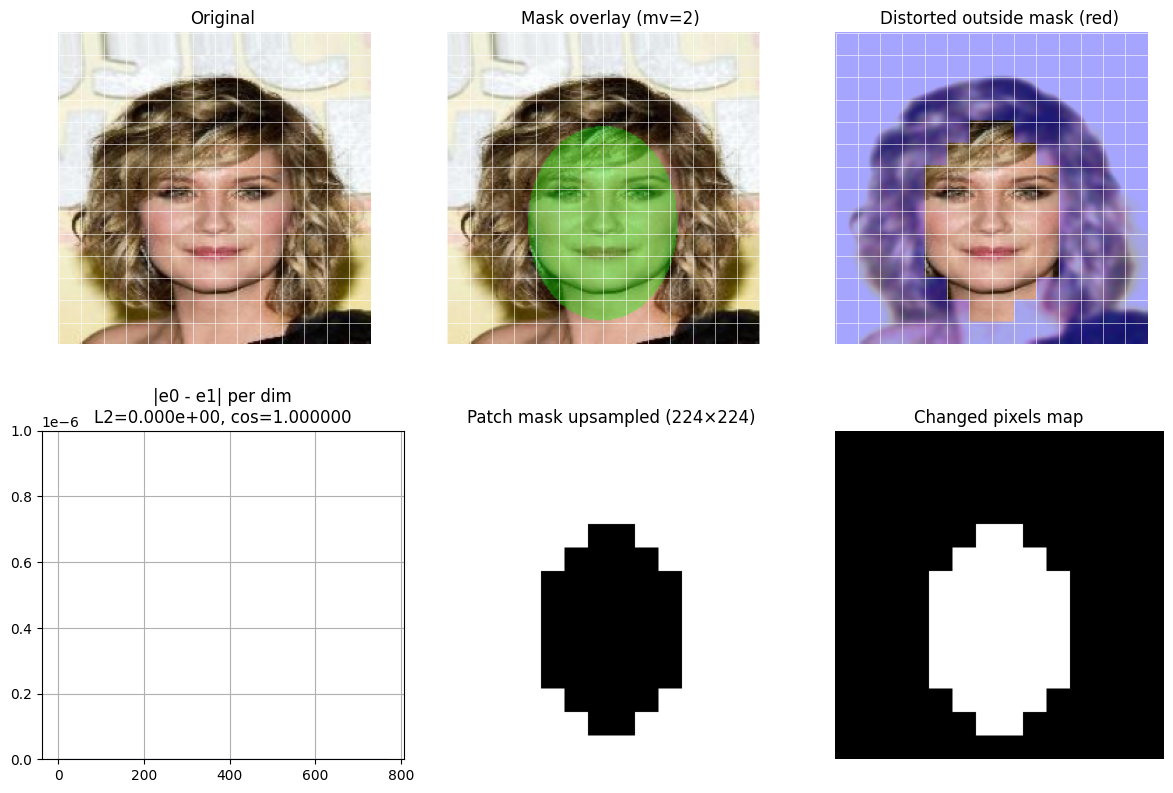

pixels changed outside-mask=39424, inside-mask=0
embeddings_equal: True
Saved figure: /kaggle/working/output/invariance_check_viz.png


In [18]:

import numpy as np, torch, cv2, matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path

IMG_SIZE, PATCH = 224, 16
OUT_DIR = Path("/kaggle/working/output"); OUT_DIR.mkdir(exist_ok=True, parents=True)

def upsample_patchmask_to_pixels(pm14: np.ndarray, patch: int = PATCH) -> np.ndarray:
    # 14x14 -> 224x224 повторением блоков 16x16
    return np.kron(pm14.astype(np.uint8), np.ones((patch, patch), dtype=np.uint8))

def distort_outside_patchmask(img224: np.ndarray, pm14: np.ndarray) -> np.ndarray:
    # искажаем ТОЛЬКО снятые патчи (где pm14==0)
    m_px = upsample_patchmask_to_pixels(pm14)
    outside = (m_px == 0).astype(np.uint8)[:, :, None]

    noisy = img224.copy().astype(np.float32)
    noise = np.random.normal(0, 30, img224.shape).astype(np.float32)
    noisy = np.clip(noisy + noise, 0, 255)
    noisy = cv2.GaussianBlur(noisy.astype(np.uint8), (11, 11), 2.0)
    alpha, beta = 1.4, 15
    noisy = np.clip(alpha * noisy + beta, 0, 255).astype(np.uint8)

    keep = (m_px == 1).astype(np.uint8)[:, :, None]
    return img224 * keep + noisy * outside

def overlay_mask(img224: np.ndarray, mask224: np.ndarray, alpha=0.35):
    # зелёный оверлей на разрешённых пикселях
    green = np.zeros_like(img224); green[...,1] = 255
    return np.where(mask224[...,None] == 1,
                    ((1-alpha)*img224 + alpha*green).astype(np.uint8),
                    img224)

@torch.no_grad()
def embed_with_patchmask_np(img_np: np.ndarray, pm14: np.ndarray):
    model.eval()
    x = val_tf(Image.fromarray(img_np)).unsqueeze(0).to(device)
    pm = torch.from_numpy(pm14).float().unsqueeze(0).to(device)
    e = model(x, patch_mask=pm, return_embed=True).cpu().numpy()[0]
    return e

def draw_grid(ax, step=PATCH, color=(1,1,1), lw=0.4):
    H, W = IMG_SIZE, IMG_SIZE
    for x in range(0, W+1, step): ax.plot([x, x], [0, H], color=color, lw=lw)
    for y in range(0, H+1, step): ax.plot([0, W], [y, y], color=color, lw=lw)

# --- выберем один пример из валидации ---
assert len(val_ds) > 0, "Валидация пуста."
row = val_ds.df.sample(1, random_state=11).iloc[0]
img0 = Image.open(row["path"]).convert("RGB").resize((IMG_SIZE, IMG_SIZE), Image.BILINEAR)
img0_np = np.array(img0)

# выберем маску: (2) или (3) если есть лэндмарки, иначе (4)
mv = 2 if row["img"] in landmarks else (3 if row["img"] in landmarks else 4)

# получаем пиксельную маску 224x224 и патч-маску 14x14
mask_px = mask_pixel_224(row["img"], mv)
pm14    = pixelmask_to_patchmask(mask_px)

# искажаем строго вне маски и считаем эмбеддинги с той же маской
img1_np = distort_outside_patchmask(img0_np, pm14)
e0 = embed_with_patchmask_np(img0_np, pm14)
e1 = embed_with_patchmask_np(img1_np, pm14)

# проверка: изменённые пиксели только снаружи?
m_px = upsample_patchmask_to_pixels(pm14)
changed = (img0_np != img1_np).any(axis=2).astype(np.uint8)
changed_inside  = int(((changed==1) & (m_px==1)).sum())
changed_outside = int(((changed==1) & (m_px==0)).sum())

# визуализация
fig = plt.figure(figsize=(12,8))

ax = plt.subplot(2,3,1)
ax.imshow(img0_np); ax.set_title(f"Original"); ax.axis("off"); draw_grid(ax)

ax = plt.subplot(2,3,2)
ax.imshow(overlay_mask(img0_np, mask_px))
ax.set_title(f"Mask overlay (mv={mv})"); ax.axis("off"); draw_grid(ax)

alpha=0.35
red = np.zeros_like(img1_np); red[...,2] = 255
vis_changed = np.where((changed[...,None]==1) & (m_px[...,None]==0),
                       ((1-alpha)*img1_np + alpha*red).astype(np.uint8),
                       img1_np)
ax = plt.subplot(2,3,3)
ax.imshow(vis_changed); ax.set_title("Distorted outside mask (red)"); ax.axis("off"); draw_grid(ax)

diff = np.abs(e0 - e1)
ax = plt.subplot(2,3,4)
ax.plot(diff, lw=0.8); ax.grid(True)
ax.set_ylim(0, max(1e-6, diff.max()*1.2))
ax.set_title(f"|e0 - e1| per dim\nL2={np.linalg.norm(e0-e1):.3e}, cos={float(np.dot(e0,e1)):.6f}")

ax = plt.subplot(2,3,5)
ax.imshow(m_px, vmin=0, vmax=1, cmap="gray_r")
ax.set_title("Patch mask upsampled (224×224)"); ax.axis("off")

ax = plt.subplot(2,3,6)
ax.imshow(changed, vmin=0, vmax=1, cmap="gray_r")
ax.set_title("Changed pixels map"); ax.axis("off")

plt.tight_layout()
fig_path = OUT_DIR/"invariance_check_viz.png"
plt.savefig(fig_path, dpi=150, bbox_inches="tight")
plt.show()

print(f"pixels changed outside-mask={changed_outside}, inside-mask={changed_inside}")
print("embeddings_equal:", bool(np.allclose(e0, e1, rtol=0, atol=1e-7)))
print("Saved figure:", fig_path)


In [ ]:
import os, pandas as pd
from pathlib import Path

IDENTITY_TXT = Path("/kaggle/input/identity-celeba/identity_CelebA.txt")

assert IDENTITY_TXT.exists(), f"Не найден {IDENTITY_TXT}"


df = val_ds.df.copy()  

if "img" not in df.columns:
    df["img"] = df["path"].map(lambda p: os.path.basename(str(p)))

#
map_df = pd.read_csv(IDENTITY_TXT, sep=r"\s+", header=None, names=["img", "id"])
map_df["img"] = map_df["img"].astype(str)
map_df["id"]  = map_df["id"].astype(int)

df = df.merge(map_df, on="img", how="left")

missing = df["id"].isna().sum()
if missing:
    print(f"⚠️ Внимание: у {missing} файлов не нашёлся id в mapping — такие строки будут удалены.")
    df = df[df["id"].notna()].copy()

df["id"] = df["id"].astype(int)
val_ds.df = df.reset_index(drop=True)

print("Готово. Колонки:", list(val_ds.df.columns))
print("Пример:")
print(val_ds.df[["img","path","id"]].head(10))


Готово. Колонки: ['img', 'pid', 'split', 'path', 'id']
Пример:
          img                                               path    id
0  006592.jpg  /kaggle/input/celeba-dataset/img_align_celeba/...  9039
1  033775.jpg  /kaggle/input/celeba-dataset/img_align_celeba/...  5321
2  090960.jpg  /kaggle/input/celeba-dataset/img_align_celeba/...  4865
3  139067.jpg  /kaggle/input/celeba-dataset/img_align_celeba/...  3745
4  059818.jpg  /kaggle/input/celeba-dataset/img_align_celeba/...  1368
5  009276.jpg  /kaggle/input/celeba-dataset/img_align_celeba/...  7845
6  148286.jpg  /kaggle/input/celeba-dataset/img_align_celeba/...  5173
7  173836.jpg  /kaggle/input/celeba-dataset/img_align_celeba/...  2823
8  110236.jpg  /kaggle/input/celeba-dataset/img_align_celeba/...  8663
9  123973.jpg  /kaggle/input/celeba-dataset/img_align_celeba/...  8448


In [ ]:

import numpy as np, torch
from PIL import Image
from pathlib import Path
from tqdm.auto import tqdm

OUT_DIR = Path("/kaggle/working/output"); OUT_DIR.mkdir(exist_ok=True, parents=True)

@torch.no_grad()
def build_gallery_embeddings(dataset_df, mask_variant=1, batch=64, save_path=None):
    model.eval()
    paths  = dataset_df["path"].tolist()
    ids    = dataset_df["id"].astype(int).to_numpy()
    embs   = []

    def make_batch(start, end):
        imgs, pms = [], []
        for pth, img_name in zip(paths[start:end], dataset_df["img"].tolist()[start:end]):
            img = Image.open(pth).convert("RGB").resize((224,224), Image.BILINEAR)
            x = val_tf(img).unsqueeze(0)  # тензор [1,3,224,224]
            pm_px = mask_pixel_224(img_name, mask_variant)
            pm14  = pixelmask_to_patchmask(pm_px)            # (14,14)
            pm = torch.from_numpy(pm14).float().unsqueeze(0) # [1,14,14]
            imgs.append(x); pms.append(pm)
        X  = torch.cat(imgs, 0).to(device)
        PM = torch.cat(pms, 0).to(device)
        return X, PM

    for s in tqdm(range(0, len(paths), batch), desc=f"gallery mv={mask_variant}"):
        X, PM = make_batch(s, min(s+batch, len(paths)))
        with torch.autocast(device_type="cuda", dtype=torch.float16, enabled=(device=="cuda")):
            E = model(X, patch_mask=PM, return_embed=True)  # [B,D], уже L2-norm
        embs.append(E.cpu().numpy())
    embs = np.vstack(embs).astype("float32")

    if save_path is None:
        save_path = OUT_DIR / f"gallery_mv{mask_variant}.npz"
    np.savez_compressed(save_path, embs=embs, ids=ids, paths=np.array(paths))
    print("Saved gallery:", save_path, "| shape:", embs.shape)
    return save_path

# соберём один раз галерею без маски (полные изображения)
GALL_PATH = build_gallery_embeddings(val_ds.df, mask_variant=1, batch=64)


gallery mv=1:   0%|          | 0/95 [00:00<?, ?it/s]

Saved gallery: /kaggle/working/output/gallery_mv1.npz | shape: (6017, 768)


In [29]:
# === RETRIEVAL VIZ: маскированный запрос -> полные изображения ===
import numpy as np, torch, faiss, matplotlib.pyplot as plt, cv2
from PIL import Image
from matplotlib import patches

def upsample_patchmask_to_pixels(pm14, patch=16):
    return np.kron(pm14.astype(np.uint8), np.ones((patch, patch), dtype=np.uint8))

def overlay_allowed(img224, mask224, alpha=0.35):
    green = np.zeros_like(img224); green[...,1] = 255
    return np.where(mask224[...,None]==1,
                    ((1-alpha)*img224 + alpha*green).astype(np.uint8),
                    img224)

def distort_outside_patchmask(img224, pm14):
    m_px = upsample_patchmask_to_pixels(pm14)
    outside = (m_px == 0).astype(np.uint8)[:, :, None]
    noisy = img224.astype(np.float32)
    noise = np.random.normal(0, 30, img224.shape).astype(np.float32)
    noisy = np.clip(noisy + noise, 0, 255)
    noisy = cv2.GaussianBlur(noisy.astype(np.uint8), (11, 11), 2.0)
    alpha, beta = 1.4, 15
    noisy = np.clip(alpha * noisy + beta, 0, 255).astype(np.uint8)
    keep = (m_px == 1).astype(np.uint8)[:, :, None]
    return img224 * keep + noisy * outside

@torch.no_grad()
def embed_query(path, img_name, mask_variant=2, distort=False):
    img = Image.open(path).convert("RGB").resize((224,224), Image.BILINEAR)
    img_np = np.array(img)
    pm_px  = mask_pixel_224(img_name, mask_variant)
    pm14   = pixelmask_to_patchmask(pm_px)
    if distort:
        img_np = distort_outside_patchmask(img_np, pm14)
        img = Image.fromarray(img_np)
    x  = val_tf(img).unsqueeze(0).to(device)
    pm = torch.from_numpy(pm14).float().unsqueeze(0).to(device)
    e  = model(x, patch_mask=pm, return_embed=True).cpu().numpy().astype("float32")
    return e, img_np, pm_px

def load_gallery(npz_path):
    z = np.load(npz_path, allow_pickle=True)
    return z["embs"].astype("float32"), z["ids"].astype(int), z["paths"]

def search_and_visualize(k=5, mask_variant_query=2, distort_query=False, gallery_npz=GALL_PATH, row=None):
    # галерея (полная, mask=all)
    G, G_ids, G_paths = load_gallery(gallery_npz)
    D = G.shape[1]
    # faiss IP на L2-нормированных == косинус
    index = faiss.IndexFlatIP(D)
    index.add(G)

    # запрос (маскированный, опц. искажённый)
    if row is None:
        row = val_ds.df.sample(1, random_state=123).iloc[0]
    q_id, q_path, q_img = int(row["id"]), row["path"], row["img"]
    q_e, q_vis, q_maskpx = embed_query(q_path, q_img, mask_variant_query, distort_query)

    # поиск
    sims, idxs = index.search(q_e, k+1)   # вернёт и self-match
    sims, idxs = sims[0], idxs[0]
    # уберём self-match, если он попал
    keep = []
    for s,i in zip(sims, idxs):
        if G_paths[i] != q_path:
            keep.append((s,i))
        if len(keep) == k:
            break
    sims = [s for s,_ in keep]; idxs = [i for _,i in keep]

    # визуализация
    fig = plt.figure(figsize=(3+3*k, 4.2))
    # Запрос
    ax = plt.subplot(1, k+1, 1)
    ax.imshow(overlay_allowed(q_vis, q_maskpx))
    ax.set_title(f"Query (mv={mask_variant_query})\nID={q_id}")
    ax.axis("off")

    # Топ-k
    hits = 0
    for j,(s,i) in enumerate(zip(sims, idxs), start=2):
        gp, gid = G_paths[i], int(G_ids[i])
        img = Image.open(gp).convert("RGB").resize((224,224), Image.BILINEAR)
        ax = plt.subplot(1, k+1, j)
        ax.imshow(img); ax.axis("off")
        ok = (gid == q_id); hits += int(ok)
        ax.set_title(f"sim={s:.3f}\nID={gid}", fontsize=9)
        # рамка: зелёная = верно, красная = нет
        color = "lime" if ok else "red"
        ax.add_patch(patches.Rectangle((0,0), 223.5, 223.5, fill=False, lw=3, edgecolor=color))
    plt.suptitle(f"Masked query → Full gallery | top-{k}  (hits={hits}/{k})", y=1.02)
    plt.tight_layout()
    plt.show()



Query -> img=033775.jpg | id=5321 | idx=0


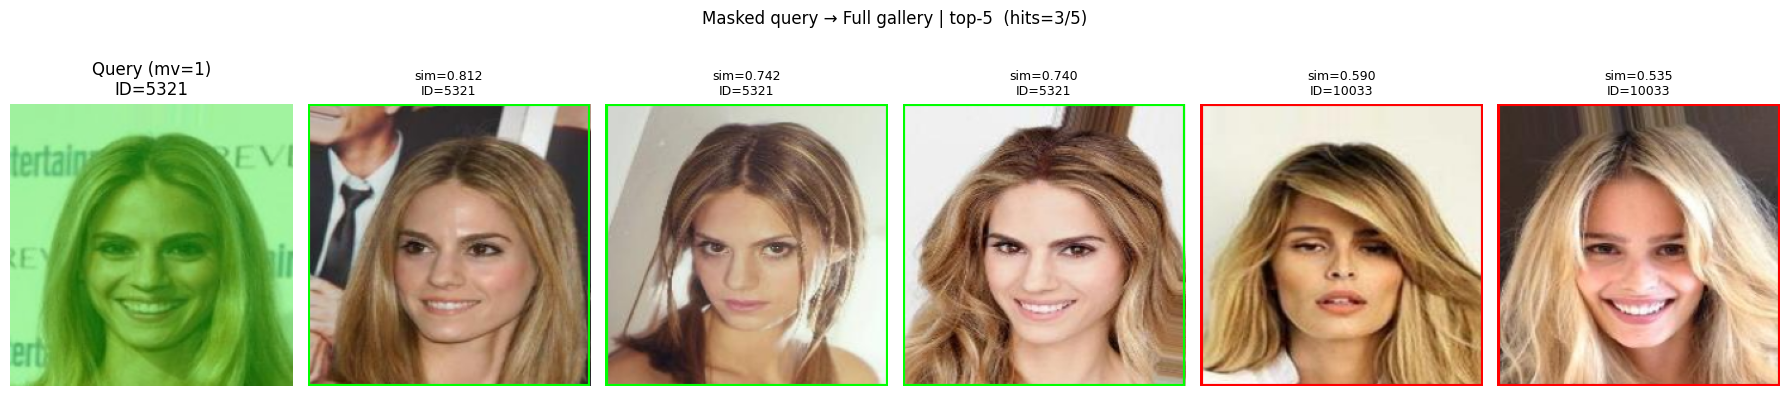

In [ ]:

# ---- 1) Настройки выбора ----
MODE = "person"      # варианты: "filename", "index", "person"
MASK_VARIANT = 1       # 1=all, 2=face_no_bg, 3=face_no_hair, 4=tiny_corner
DISTORT = False         # исказить вне маски в запросе (наглядный частичный запрос)
TOPK = 5               # сколько результатов показывать

# для MODE="filename"
QUERY_IMG = "000123.jpg"  

# для MODE="index"
QUERY_INDEX = 42           # ← номер строки в val_ds.df (0..len-1)

# для MODE="person"
PERSON_ID = 5321         # ← id из identity_CelebA.txt
PERSON_SHOT_INDEX = 0     


if MODE == "filename":
    row = val_ds.df.loc[val_ds.df["img"] == QUERY_IMG]
    assert len(row) > 0, f"Файл {QUERY_IMG} не найден в val_ds.df['img']"
    row = row.iloc[0]

elif MODE == "index":
    assert 0 <= QUERY_INDEX < len(val_ds.df), "QUERY_INDEX вне диапазона"
    row = val_ds.df.iloc[QUERY_INDEX]

elif MODE == "person":
    sub = val_ds.df[val_ds.df["id"] == int(PERSON_ID)].reset_index(drop=True)
    assert len(sub) > 0, f"id={PERSON_ID} отсутствует в валидации"
    assert 0 <= PERSON_SHOT_INDEX < len(sub), "PERSON_SHOT_INDEX вне диапазона"
    row = sub.iloc[PERSON_SHOT_INDEX]

else:
    raise ValueError("MODE должен быть: 'filename', 'index' или 'person'")

print(f"Query -> img={row['img']} | id={row['id']} | idx={row.name}")

# ---- 3) Запуск визуализации поиска ----
search_and_visualize(
    k=TOPK,
    mask_variant_query=MASK_VARIANT,
    distort_query=DISTORT,
    row=row
)
